In [1]:
import gym
import random
import numpy as np

# Create environment
env_name = 'LunarLander-v2'
env = gym.make(env_name)

def eval_env_random_actions(env, episodes = 10, render = True):
    all_rewards = []
    for episode in range(1, episodes):
        env.reset() # Restart the agent at the beginning
        done = False # If the agent has completed the level
        score = 0 # Called score not return cause it's python

        while not done:
            if render:
                env.render()
            random_action = env.action_space.sample() # Do random actions
            state, reward, done, info = env.step(random_action) 
            score += reward
        print('Episode: {}\t\tScore: {}'.format(episode, score))
        all_rewards.append(score)  
    print("\nMean reward:", np.mean(all_rewards))
    env.close()
    
# eval_env_random_actions(env)

In [2]:
#================================================================
#
#   File name   : LunarLander-v2_PPO.py
#   Author      : PyLessons
#   Created date: 2020-10-10
#   Website     : https://pylessons.com/
#   GitHub      : https://github.com/pythonlessons/Reinforcement_Learning
#   Description : LunarLander-v2 PPO discrete agent
#   TensorFlow  : 2.3.1
#
#================================================================
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1:cpu, 0:first gpu
import random
import gym
import pylab
import numpy as np
import tensorflow as tf
from tensorboardX import SummaryWriter

In [3]:
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend
import copy

In [4]:
from threading import Thread, Lock
from multiprocessing import Process, Pipe
import time

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

In [5]:
class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Dense(512, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(256, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(64,  activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = backend.clip(prob, 1e-10, 1.0)
        old_prob = backend.clip(old_prob, 1e-10, 1.0)

        ratio = backend.exp(backend.log(prob) - backend.log(old_prob))
        
        p1 = ratio * advantages
        p2 = backend.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -backend.mean(backend.minimum(p1, p2))

        entropy = -(y_pred * backend.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * backend.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def predict(self, state):
        return self.Actor.predict(state)

In [6]:
class Environment(Process):
    def __init__(self, env_idx, child_conn, env_name, state_size, action_size, visualize=False):
        super(Environment, self).__init__()
        self.env = gym.make(env_name)
        self.is_render = False #visualize
        self.env_idx = env_idx
        self.child_conn = child_conn
        self.state_size = state_size
        self.action_size = action_size

    def run(self):
        super(Environment, self).run()
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        self.child_conn.send(state)
        while True:
            action = self.child_conn.recv()
            if self.is_render and self.env_idx == 0:
                self.env.render()

            state, reward, done, info = self.env.step(action)
            state = np.reshape(state, [1, self.state_size])

            if done:
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

            self.child_conn.send([state, reward, done, info])

In [7]:
class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        old_values = Input(shape=(1,))

        V = Dense(512, activation="relu", kernel_initializer='he_uniform')(X_input)
        V = Dense(256, activation="relu", kernel_initializer='he_uniform')(V)
        V = Dense(64, activation="relu", kernel_initializer='he_uniform')(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=[X_input, old_values], outputs = value)
        self.Critic.compile(loss=[self.critic_PPO2_loss(old_values)], optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, values):
        def loss(y_true, y_pred):
            LOSS_CLIPPING = 0.2
            clipped_value_loss = values + backend.clip(y_pred - values, -LOSS_CLIPPING, LOSS_CLIPPING)
            v_loss1 = (y_true - clipped_value_loss) ** 2
            v_loss2 = (y_true - y_pred) ** 2
            
            value_loss = 0.5 * backend.mean(backend.maximum(v_loss1, v_loss2))
            #value_loss = backend.mean((y_true - y_pred) ** 2) # standard PPO loss
            return value_loss
        return loss

    def predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

In [8]:
class PPOAgent:
    # PPO Main Optimization Algorithm
    def __init__(self, env_name):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.shape
        self.EPISODES = 10_0#00 # total episodes to train through all environments
        self.episode = 0 # used to track the episodes total count of episodes played through all thread environments
        self.max_average = 0 # when average score is above 0 model will be saved
        self.lr = 0.00025
        self.epochs = 10 # training epochs
        self.shuffle=False
        self.Training_batch = 1000
        #self.optimizer = RMSprop
        self.optimizer = Adam

        self.replay_count = 0
        self.writer = SummaryWriter(comment="_"+self.env_name+"_"+self.optimizer.__name__+"_"+str(self.lr))
        
        # Instantiate plot memory
        self.scores_, self.episodes_, self.average_ = [], [], [] # used in matplotlib plots

        # Create Actor-Critic network models
        self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"

        
    def act(self, state):
        """ example:
        pred = np.array([0.05, 0.85, 0.1])
        action_size = 3
        np.random.choice(a, p=pred)
        result>>> 1, because it have the highest probability to be taken
        """
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        return action, action_onehot, prediction

    def discount_rewards(self, reward):#gaes is better
        # Compute the gamma-discounted rewards over an episode
        # We apply the discount and normalize it to avoid big variability of rewards
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= (np.std(discounted_r) + 1e-8) # divide by standard deviation
        return discounted_r

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.9, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions 
        values = self.Critic.predict(states)
        next_values = self.Critic.predict(next_states)

        # Compute discounted rewards and advantages
        #discounted_r = self.discount_rewards(rewards)
        #advantages = np.vstack(discounted_r - values)
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        '''
        pylab.plot(advantages,'.')
        pylab.plot(target,'-')
        ax=pylab.gca()
        ax.grid(True)
        pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
        pylab.show()
        '''
        # stack everything to numpy array
        # pack all advantages, predictions and actions to y_true and when they are received
        # in custom PPO loss function we unpack it
        y_true = np.hstack([advantages, predictions, actions])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        c_loss = self.Critic.Critic.fit([states, values], target, epochs=self.epochs, verbose=0, shuffle=self.shuffle)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1
 
    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)

    def save(self):
        self.Actor.Actor.save_weights(self.Actor_name)
        self.Critic.Critic.save_weights(self.Critic_name)
        
    pylab.figure(figsize=(18, 9))
    pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
    
    def PlotModel(self, score, episode):
        self.scores_.append(score)
        self.episodes_.append(episode)
        self.average_.append(sum(self.scores_[-50:]) / len(self.scores_[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes_, self.scores_, 'b')
            pylab.plot(self.episodes_, self.average_, 'r')
            pylab.title(self.env_name+" PPO training cycle", fontsize=18)
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.grid(True)
                pylab.savefig(self.env_name+".png")
            except OSError:
                pass
        # saving best models
        if self.average_[-1] >= self.max_average:
            self.max_average = self.average_[-1]
            self.save()
            SAVING = "SAVING"
            # decreaate learning rate every saved model
            self.lr *= 0.95
            backend.set_value(self.Actor.Actor.optimizer.learning_rate, self.lr)
            backend.set_value(self.Critic.Critic.optimizer.learning_rate, self.lr)
        else:
            SAVING = ""

        return self.average_[-1], SAVING
    
    def run(self): # train only when episode is finished
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            while not done:
#                 self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)
                    
                    self.replay(states, actions, rewards, predictions, dones, next_states)

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])

            if self.episode >= self.EPISODES:
                break
        self.env.close()

    def run_batch(self): # train every self.Training_batch episodes
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            for t in range(self.Training_batch):
#                 self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])
                    
            self.replay(states, actions, rewards, predictions, dones, next_states)
            if self.episode >= self.EPISODES:
                break
        self.env.close()  

        
    def run_multiprocesses(self, num_worker = 4):
        works, parent_conns, child_conns = [], [], []
        for idx in range(num_worker):
            parent_conn, child_conn = Pipe()
            work = Environment(idx, child_conn, self.env_name, self.state_size[0], self.action_size, False)
            work.start()
            works.append(work)
            parent_conns.append(parent_conn)
            child_conns.append(child_conn)

        states =        [[] for _ in range(num_worker)]
        next_states =   [[] for _ in range(num_worker)]
        actions =       [[] for _ in range(num_worker)]
        rewards =       [[] for _ in range(num_worker)]
        dones =         [[] for _ in range(num_worker)]
        predictions =   [[] for _ in range(num_worker)]
        score =         [0 for _ in range(num_worker)]

        state = [0 for _ in range(num_worker)]
        for worker_id, parent_conn in enumerate(parent_conns):
            state[worker_id] = parent_conn.recv()

        while self.episode < self.EPISODES:
            predictions_list = self.Actor.predict(np.reshape(state, [num_worker, self.state_size[0]]))
            actions_list = [np.random.choice(self.action_size, p=i) for i in predictions_list]

            for worker_id, parent_conn in enumerate(parent_conns):
                parent_conn.send(actions_list[worker_id])
                action_onehot = np.zeros([self.action_size])
                action_onehot[actions_list[worker_id]] = 1
                actions[worker_id].append(action_onehot)
                predictions[worker_id].append(predictions_list[worker_id])

            for worker_id, parent_conn in enumerate(parent_conns):
                next_state, reward, done, _ = parent_conn.recv()

                states[worker_id].append(state[worker_id])
                next_states[worker_id].append(next_state)
                rewards[worker_id].append(reward)
                dones[worker_id].append(done)
                state[worker_id] = next_state
                score[worker_id] += reward

                if done:
                    average, SAVING = self.PlotModel(score[worker_id], self.episode)
                    print("episode: {}/{}, worker: {}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, worker_id, score[worker_id], average, SAVING))
                    self.writer.add_scalar(f'Workers:{num_worker}/score_per_episode', score[worker_id], self.episode)
                    self.writer.add_scalar(f'Workers:{num_worker}/learning_rate', self.lr, self.episode)
                    score[worker_id] = 0
                    if(self.episode < self.EPISODES):
                        self.episode += 1
                        
            for worker_id in range(num_worker):
                if len(states[worker_id]) >= self.Training_batch:
                    self.replay(states[worker_id], actions[worker_id], rewards[worker_id], predictions[worker_id], dones[worker_id], next_states[worker_id])
                    
                    states[worker_id] = []
                    next_states[worker_id] = []
                    actions[worker_id] = []
                    rewards[worker_id] = []
                    dones[worker_id] = []
                    predictions[worker_id] = []

        # terminating processes after while loop
        works.append(work)
        for work in works:
            work.terminate()
            print('TERMINATED:', work)
            work.join()
            

    def test(self, test_episodes = 100):
        self.load()
        for e in range(100):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size[0]])
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.Actor.predict(state)[0])
                state, reward, done, _ = self.env.step(action)
                state = np.reshape(state, [1, self.state_size[0]])
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, test_episodes, score))
                    break
        self.env.close()

<Figure size 1296x648 with 0 Axes>

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-03-21 16:32:31.515364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 16:32:31.542240: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc9893520d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-21 16:32:31.542270: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


episode: 1/100, score: -182.16741955202667, average: -182.17 
episode: 2/100, score: -443.26362134065255, average: -312.72 
episode: 3/100, score: -144.21004542806807, average: -256.55 
episode: 4/100, score: -114.9286060255158, average: -221.14 
episode: 5/100, score: -113.23240801493205, average: -199.56 
episode: 6/100, score: -232.80321635518146, average: -205.10 
episode: 7/100, score: -105.56557828126434, average: -190.88 
episode: 8/100, score: -323.18151130360695, average: -207.42 
episode: 9/100, score: -120.80619632553001, average: -197.80 
episode: 10/100, score: -5.5730202877115715, average: -178.57 
episode: 11/100, score: -123.11238016427494, average: -173.53 
episode: 12/100, score: -132.04349235696816, average: -170.07 
episode: 13/100, score: -93.43720615032399, average: -164.18 
episode: 14/100, score: -159.8532756462103, average: -163.87 
episode: 15/100, score: -51.850137386476376, average: -156.40 
episode: 16/100, score: -134.28366024856405, average: -155.02 
epis

KeyboardInterrupt: 

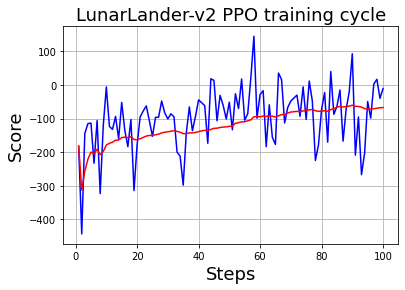

In [9]:
# if __name__ == "__main__":
env_name = 'LunarLander-v2'
agent = PPOAgent(env_name)
agent.run() # train as PPO, train every epesode
#agent.run_batch() # train as PPO, train every batch, trains better
#agent.run_multiprocesses(num_worker = 8)  # train PPO multiprocessed (fastest)


In [10]:
agent.test()

OSError: Unable to open file (unable to open file: name = 'LunarLander-v2_PPO_Actor.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)